# Quick intro


## Competition description
The Connectivity Map, a project within the Broad Institute of MIT and Harvard, together with the Laboratory for Innovation Science at Harvard (LISH), presents this challenge with the goal of advancing drug development through improvements to MoA prediction algorithms.

### What is the Mechanism of Action (MoA) of a drug? And why is it important?

In the past, scientists derived drugs from natural products or were inspired by traditional remedies. Very common drugs, such as paracetamol, known in the US as acetaminophen, were put into clinical use decades before the biological mechanisms driving their pharmacological activities were understood. Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

### How do we determine the MoAs of a new drug?

One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.

In this competition, you will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, you will have access to MoA annotations for more than 5,000 drugs in this dataset.

As is customary, the dataset has been split into testing and training subsets. Hence, your task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.
 
### What should I expect the data format to be & what am I predicting?
In this competition, you will be predicting multiple targets of the Mechanism of Action (MoA) response(s) of different samples (sig_id), given various inputs such as gene expression data and cell viability data.

**Two notes:**

the training data has an additional (optional) set of MoA labels that are not included in the test data and not used for scoring.
the re-run dataset has approximately 4x the number of examples seen in the Public test.
**Files**
```train_features.csv```  - Features for the training set. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).

``` train_targets_scored.csv```  - The binary MoA targets that are scored.  
``` train_targets_nonscored.csv```  - Additional (optional) binary MoA responses for the training data. These are not predicted nor scored.  
``` test_features.csv```  - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.  
``` sample_submission.csv```  - A submission file in the correct format.  

The final submission-file should contain a header and have the following format:


## Submission File
You must predict a probability of a positive target for each sig_id-<MoA> pair. The id used for the submission is created by concatenating the sig_id with the MoA target for which you are predicting. The file should have a header and be in the following format:
``` 
sig_id,11-beta-hsd1_inhibitor,ace_inhibitor,...,wnt_inhibitor
id_000644bb2,0.32,0.01,...,0.57
id_000a6266a,0.88,0.27,...,0.42
etc...
``` 




# Update history:

### This notebook is largely derived from my notebook here: https://www.kaggle.com/chrisden/6-82-quantile-reg-lr-schedulers-checkpointsNew and can easily be modified with CV-backed Random Grid Hyperparameter Search by using [this](https://www.kaggle.com/chrisden/6-82x-cv-backed-hyperp-gridsearch-quantile-reg).
V8: Plot corrections  
V2-5: Corrections, Adoptions, introducing plotting & evaluation of results  
V1 Initial commit 


## Domain knowledge

### Some domain knowledge can be gained from watching the following video and from additionally watching [here.](https://www.youtube.com/watch?v=UMxsZdVrA7A&ab_channel=PharmaStudy)

In [ ]:
from IPython.display import HTML
HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/PGzT3cTPah8" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

## GPU or CPU?
This notebook can be run using GPU or CPU. Using GPU is roughly 5+ times faster than CPU.

## Load all dependencies you need
<span style="color:darkgreen ;font-family: Impact; font-size:13;"> from  </span> coffee  <span style="color:darkgreen ;font-family: Impact; font-size:13;"> import  </span> ***** 

In [ ]:
import numpy as np
import random
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
from timeit import timeit
from tqdm import tqdm
from PIL import Image

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

#color
from colorama import Fore, Back, Style

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


Let's start seeding everything to make results somewhat reproducible. Anyway, in keras it is quite hard to get 100% reproducible results.

In [ ]:
def seed_everything(seed): 
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# First glimpse at the data

In [ ]:
ROOT = '../input/lish-moa'

train_features_df = pd.read_csv(f'{ROOT}/train_features.csv')
print(f'Train data has {train_features_df.shape[0]} rows and {train_features_df.shape[1]} columnns and looks like this:')


In [ ]:
train_features_df.sample(10)

In [ ]:
# CHECK FOR DUPLICATES & DEAL WITH THEM
# keep = False: All duplicates will be shown
dupRows_df = train_features_df[train_features_df.duplicated(subset = ['sig_id', 'cp_type'], 
                                                            keep = False )]
dupRows_df.head()
print(f'There are {dupRows_df.shape[0]} duplicates.')

In [ ]:
test_features_df = pd.read_csv(f'{ROOT}/test_features.csv')
print(f'Test data has {test_features_df.shape[0]} rows and {test_features_df.shape[1]} columnns, has no duplicates and looks like this:')
test_features_df.head()

Let's check if there are overlapping ```sig_ids``` in train and in test data. I can think of two (but of course there are many more) fast and clean ways on how to do this:
1. Converting the unique values to two sets and check for the intersection, or
2. using a generator expression performing iteration over the lists
Let's use both of them and compare the speed!

In [ ]:
uniq_test = test_features_df['sig_id'].unique()
uniq_train = train_features_df['sig_id'].unique()

In [ ]:
def intersec_using_sets_intersection(uniq_test, uniq_train):
    return bool(set(uniq_test) & set(uniq_train))

In [ ]:
def intersec_using_generator_expression(uniq_test, uniq_train):
    return any(i in uniq_test for i in uniq_train)

In [ ]:
def time_sets():
    return intersec_using_sets_intersection(uniq_test, uniq_train)

def time_generator():
    return intersec_using_generator_expression(uniq_test, uniq_train)

duration_sets = timeit(time_sets, number = 3)
duration_generator = timeit(time_generator, number = 3)

print(f"Using the set-intersection takes {duration_sets / 3:.5f} sec, while the generator expression takes {duration_generator / 3:.3f} sec. Using set-intersection is {duration_generator/duration_sets:.0f} times faster!" )


Besides that: there is no intersection/overlapping between train and test sid_ids as we can see here:

In [ ]:
intersec_using_sets_intersection(uniq_test, uniq_train)

This is a rather large dataset with respect to the number of roughly ~ 900 columns/features. As [headsortails](https://www.kaggle.com/headsortails) describes perfectly: 
> From the data description we learn that features starting with “g-” encode gene expression data (there are 772 of those), and features starting with “c-” (100 in total) show cell viability data.
> 
> In addition, we have 3 “cp_” features: cp_type incidates the sample treatment, while cp_time and cp_dose encode the duration and dosage of the treatment.
> 
> The sig_id is the unique primary key of the sample.


This clearly screams for feature selection & dimensionality-reduction methodologies, which I will tackle in a later version of this notebook.

# Data Wrangling
In this section we are going to do all the Data-Wrangling and pre-processing. For this we are going to define some functions and transformations, which then are applied to the data.
Let's start with a look into the sample submission file.


In [ ]:
## CHECK SUBMISSION FORMAT
sub_df = pd.read_csv(f"{ROOT}/sample_submission.csv")

print(f"The sample submission contains: {sub_df.shape[0]} rows and {sub_df.shape[1]} columns.")

In [ ]:
sub_df.head()

This is already in a format which we can easily use for making our predictions. The DataFrame has 207 columns, resulting in 207 - 1 (sig_id) = 206 values to predict.


The first big challenge is data wrangling: 
We could see in the ```train_features_df``` a column called ```cp_type```, which indicates whether a real medical compound (cp_vehicle) or with a control perturbation (ctrl_vehicle) was used. Control perturbations have no MoAs.

To preprocess the data with this knowledge, we are going to use a modified version of some nice code introduced [here](https://www.kaggle.com/simakov/keras-multilabel-neural-network-v1-2) using the [pandas df.map function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html): 


In [ ]:
def preprocess(df):
    # make a copy to not change original df
    _df = df.copy()
    # transform string containing columns to numeric values
    _df.loc[:, 'cp_type'] = _df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    _df.loc[:, 'cp_dose'] = _df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})    
    
    # delete sig_id column as we dont need it anymore
    del _df['sig_id']
       
    return _df

As we have tons of features and everything is screaming ["Curse of Dimensionality!"](https://en.wikipedia.org/wiki/Curse_of_dimensionality), we are going to reduce the dimensionality a bit. To save runtime, we are not going to run the dimensionality-reduction right here, but we are going to use the results from this notebook: https://www.kaggle.com/simakov/keras-multilabel-neural-network-v1-2. In the following you can see the top feature columns:

In [ ]:
# use top features from https://www.kaggle.com/simakov/keras-multilabel-neural-network-v1-2
top_feats = [  0,   1,   2,   3,   5,   6,   8,   9,  10,  11,  12,  14,  15,
        16,  18,  19,  20,  21,  23,  24,  25,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  44,  45,  46,
        48,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        63,  64,  65,  66,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        78,  79,  80,  81,  82,  83,  84,  86,  87,  88,  89,  90,  92,
        93,  94,  95,  96,  97,  99, 100, 101, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       149, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 163, 164,
       165, 166, 167, 168, 169, 170, 172, 173, 175, 176, 177, 178, 180,
       181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 195,
       197, 198, 199, 202, 203, 205, 206, 208, 209, 210, 211, 212, 213,
       214, 215, 218, 219, 220, 221, 222, 224, 225, 227, 228, 229, 230,
       231, 232, 233, 234, 236, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 248, 249, 250, 251, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 263, 265, 266, 268, 270, 271, 272, 273, 275, 276, 277, 279,
       282, 283, 286, 287, 288, 289, 290, 294, 295, 296, 297, 299, 300,
       301, 302, 303, 304, 305, 306, 308, 309, 310, 311, 312, 313, 315,
       316, 317, 320, 321, 322, 324, 325, 326, 327, 328, 329, 330, 331,
       332, 333, 334, 335, 338, 339, 340, 341, 343, 344, 345, 346, 347,
       349, 350, 351, 352, 353, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 368, 369, 370, 371, 372, 374, 375, 376, 377,
       378, 379, 380, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
       392, 393, 394, 395, 397, 398, 399, 400, 401, 403, 405, 406, 407,
       408, 410, 411, 412, 413, 414, 415, 417, 418, 419, 420, 421, 422,
       423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435,
       436, 437, 438, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 468, 469, 471, 472, 473, 474, 475, 476, 477, 478, 479, 482,
       483, 485, 486, 487, 488, 489, 491, 492, 494, 495, 496, 500, 501,
       502, 503, 505, 506, 507, 509, 510, 511, 512, 513, 514, 516, 517,
       518, 519, 521, 523, 525, 526, 527, 528, 529, 530, 531, 532, 533,
       534, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547,
       549, 550, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563,
       564, 565, 566, 567, 569, 570, 571, 572, 573, 574, 575, 577, 580,
       581, 582, 583, 586, 587, 590, 591, 592, 593, 595, 596, 597, 598,
       599, 600, 601, 602, 603, 605, 607, 608, 609, 611, 612, 613, 614,
       615, 616, 617, 619, 622, 623, 625, 627, 630, 631, 632, 633, 634,
       635, 637, 638, 639, 642, 643, 644, 645, 646, 647, 649, 650, 651,
       652, 654, 655, 658, 659, 660, 661, 662, 663, 664, 666, 667, 668,
       669, 670, 672, 674, 675, 676, 677, 678, 680, 681, 682, 684, 685,
       686, 687, 688, 689, 691, 692, 694, 695, 696, 697, 699, 700, 701,
       702, 703, 704, 705, 707, 708, 709, 711, 712, 713, 714, 715, 716,
       717, 723, 725, 727, 728, 729, 730, 731, 732, 734, 736, 737, 738,
       739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751,
       752, 753, 754, 755, 756, 758, 759, 760, 761, 762, 763, 764, 765,
       766, 767, 769, 770, 771, 772, 774, 775, 780, 781, 782, 783, 784,
       785, 787, 788, 790, 793, 795, 797, 799, 800, 801, 805, 808, 809,
       811, 812, 813, 816, 819, 820, 821, 822, 823, 825, 826, 827, 829,
       831, 832, 833, 834, 835, 837, 838, 839, 840, 841, 842, 844, 845,
       846, 847, 848, 850, 851, 852, 854, 855, 856, 858, 860, 861, 862,
       864, 867, 868, 870, 871, 873, 874]

In [ ]:
## use top features extracted by feature engineering above
X_feature_cols = top_feats
Y_feature_cols = top_feats

In [ ]:
## GET TRAINING DATA AND TARGET VALUE

# get target values
train_targets_df = pd.read_csv(f"{ROOT}/train_targets_scored.csv")
del train_targets_df['sig_id']
Y_train = train_targets_df.astype(float).values


# get training & test data, apply preprocessing
X_train = preprocess(train_features_df).astype(float).values
X_test = preprocess(test_features_df).astype(float).values

# extract feature columns
X_feature_cols = preprocess(train_features_df).columns
Y_feature_cols = train_targets_df.columns

# Model & Loss
In this section we are going to define the loss & a first model.
First we are taking care of the model evaluatiation metric and the loss. We are trying to minimize the following, which is mean log-loss. A nice (and SHORT! ;)) explanation about log-loss can be found [here](https://www.kaggle.com/dansbecker/what-is-log-loss).
**(PLEASE CORRECT MY IF MY UNDERSTANDING IS NOT PRECISELY CORRECT)**

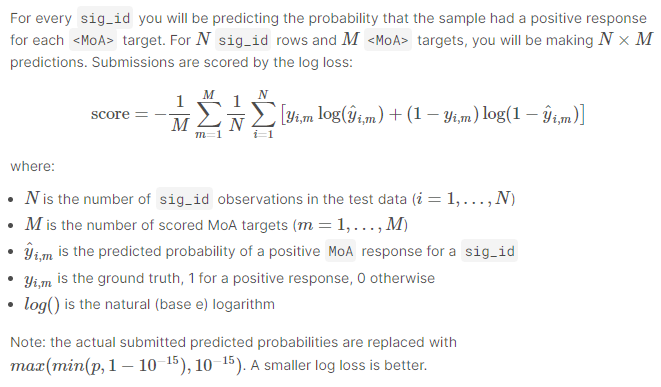






# <font color='blue'>CONFIG Section </font>

In this section you can configure the following:
* Features used for training
* Basic training setup: BATCH_SIZE and EPOCHS,
* Optimizers, Learning-Rate-Schedulers incl. Learning Rate start- & endpoint
* Custom Logging Callback
* Checkpoint-Saving Callback

The Learning-Rate scheduler below is inspired by Chris great [Melanoma-detection notebook](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords).  
Feel free to experiment with the scheduler and it's max/min and decay values.

### Ever wondered why lr_max is scaled by BATCH_SIZE and therefore bigger for larger batches?
The reason for this is the following: the larger the BATCH_SIZE, the more averaged & smoothened a step of gradient decent is and the bigger our confidence in the *direction* of the step is. As there is less "randomness" in a huge averaged batch (compared with for example Stochastic Gradient Decent (=SGD) with batch size = 1) and our confidence in the direction is higher, the learning rate can be bigger to advance fast to the optimum.

In [ ]:
######## CONFIG ########
# be careful, the resulsts are VERY SEED-DEPENDEND!
seed_everything(1949)


### Basics for training:

EPOCHS = 220
BATCH_SIZE = 64

### Optimizers
# choose "ADAM" or "SGD"
OPTIMIZER = "SGD"

### Learning Rate Scheduler
def get_lr_callback(batch_size = 64, plot = False):
    """Returns a lr_scheduler callback which is used for training.
    Feel free to change the values below!
    """
    lr_start   = 0.001
    lr_max     = 0.001 * BATCH_SIZE # higher batch size --> higher lr
    lr_min     = 0.00001
    # 30% of all epochs are used for ramping up the LR and then declining starts
    lr_ramp_ep = EPOCHS * 0.3
    lr_sus_ep  = 0
    lr_decay   = 0.9

    def lr_scheduler(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max

            else:
                lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

            return lr
    
    if plot == False:
        # get the Keras-required callback with our LR for training
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler,verbose = False)
        return lr_callback 
    
    else: 
        return lr_scheduler
    
# plot & check the LR-Scheulder for sanity-check
lr_scheduler_plot = get_lr_callback(batch_size = 64, plot = True)
rng = [i for i in range(EPOCHS)]
y = [lr_scheduler_plot(x) for x in rng]
plt.plot(rng, y)
print(f"Learning rate schedule: {y[0]:.3f} to {max(y):.3f} to {y[-1]:.3f}")


# logging & saving
LOGGING = True

# defining custom callbacks
class LogPrintingCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs = None):
        print("Training started")
        self.val_loss = [] 
        #self.val_score = [] not used for now
        
    def on_epoch_end(self, epoch, logs = None):
        self.val_loss.append(logs['val_loss']) 
        # self.val_score.append(logs['val_score']) # not used for now
        # logging: reduce printing of log-messages
        if epoch % int((EPOCHS/15)) == 0 or epoch == (EPOCHS -1 ):
            print(f"The average val-loss for epoch {epoch} is {logs['val_loss']:.4f}") 
            
    def on_train_end(self, lowest_val_loss, logs = None):
        # get index of best epoch
        best_epoch = np.argmin(self.val_loss)
        # get score in best epoch
        lowest_loss = self.val_loss[best_epoch]
        print(f"Stop training, best model was found and saved in epoch {best_epoch + 1} with loss: {lowest_loss}."
              f" Final results in this fold (last epoch):") 
        
        
def get_checkpont_saver_callback(fold):
    checkpt_saver = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold,
        monitor = 'val_loss',
        verbose = 0,
        save_best_only = True,
        save_weights_only = True,
        mode = 'min',
        save_freq = 'epoch')
    
    return checkpt_saver

## Neural Network Model
In this section we build an initial neural Network.

For the architecture: It's good practice to use numbers of units following the schema 2^x, with x element of N (= resulting in 1, 2, 4, 8, 16, 32, 64, 128,..).  
We are going to use dropout for regularization and not a too broad and deep network, as the training data is very limited.

### Normalization & Regularization
We are going to use weight-normalization (link to the paper, click [here](https://arxiv.org/abs/1602.07868)) from ```tensorflow_addons``` to support faster convergence. 
The authors describe the method like this:
> Weight normalization: a reparameterization of the weight vectors in a neural network that decouples the length of those weight vectors from their direction. By reparameterizing the weights in this way we improve the conditioning of the optimization problem and we speed up convergence of stochastic gradient descent. Our reparameterization is inspired by batch normalization but does not introduce any dependencies between the examples in a minibatch.

Additionally we gain more robustness for the choosing of the hyperparameter learning rate. Cited from page 3:
> Empirically, we find that the ability to grow the norm ||v|| makes optimization of neural networks
> with weight normalization very robust to the value of the learning rate: If the learning rate is too
> large, the norm of the unnormalized weights grows quickly until an appropriate effective learning rate
> is reached.

### Activation function
As the given task without the usage of images is not very compute-intensive (you don't need a GPU, CPU will do), we will change the activation-function from 'relu' to 'elu'.
For more info you can read [here.](https://mlfromscratch.com/activation-functions-explained/#elu), below you can find a short summary:

**Pros**
* Avoids the "dead ReLu" problem: ReLus provides activation-values & gradients of 0 for negative input values
* Produces activations for negative inputs instead of letting them be zero when calculating the gradient.
* Produces negative outputs, which helps the network nudge weights and biases in the right directions for negative inputs, too.

**Cons**
* Introduces longer computation time, because of the exponential operation included.
* Does not avoid the exploding gradient problem.

In [ ]:
import tensorflow_addons as tfa

def get_model(num_inputs, optimizer = 'ADAM', lr = 0.01):
    "Creates and returns a model"    
    # instantiate optimizer
    optimizer = tf.keras.optimizers.Adam(lr = lr) if optimizer == 'ADAM' else tf.keras.optimizers.SGD(lr = lr)
    
    # create model     
    model = tf.keras.Sequential([
    Layers.Input(num_inputs),
    Layers.BatchNormalization(),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(6144, activation = "elu")),
    Layers.BatchNormalization(),
    Layers.Dropout(0.4),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(6144, activation = "elu")),
    Layers.BatchNormalization(),
    Layers.Dropout(0.4),    
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation = "sigmoid"))
    ])
        
    model.compile(loss = 'binary_crossentropy', 
                  optimizer = optimizer, 
                  metrics=["accuracy", "AUC"])
    
    return model

In [ ]:
## Create neural Network
# the number of input neurons equals the number of columns in train,
# which is identically to the number of features/columns in test
neuralNet = get_model(num_inputs = len(X_feature_cols), optimizer = OPTIMIZER, lr = 0.5)
neuralNet.summary()

# Training
We we do not have an intersection between training and test data, we don't need to focus on creating leak-free folds to get a robust **cross-validation strategy**. But we should use some stratification for creating Please note, that we  don't  use any  proper stratification currently!

During testing several LR-Schedulers & value-combinations, it turned out that the LR-Scheduler was always outperformed by simply using ReduceLROnPlateau, so I am going to use ReduceLROnPlateau by default, but you can easily change it with un-commenting a row in belows-code.

In [ ]:
## Non-Stratified KFold-split (can be further enhanced with stratification!)
"""K-Folds cross-validator.
Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
"""

NFOLDS = 5

# set all columns which we need to predict to zero to initialize
train_preds_df = train_targets_df.copy()
train_preds_df.loc[:, Y_feature_cols] = 0
sub_df.loc[:, Y_feature_cols] = 0

fold = 0
for n, (train_idx, val_idx) in enumerate(KFold(n_splits = NFOLDS, shuffle = True).split(X_train)):
    fold += 1
    print(f"FOLD {fold}:")
    
    # LR Scheduler
    reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                                  factor = 0.6,
                                                                  patience = 3,
                                                                  verbose = 1,
                                                                  epsilon = 1e-4,
                                                                  mode = 'min')
    
    callbacks = [reduce_lr_loss]
    # callbacks = [get_lr_callback(BATCH_SIZE)] un-comment if you want to use the learning-rate scheduler
    
    # callbacks: logging & model saving with checkpoints each fold
    if LOGGING == True:
        callbacks +=  [get_checkpont_saver_callback(fold),                     
                     LogPrintingCallback()]

    # build and train model
    model = get_model(num_inputs = len(X_feature_cols), optimizer = OPTIMIZER, lr = 0.1)
    
    history = model.fit(X_train[train_idx], 
              Y_train[train_idx],
              batch_size = BATCH_SIZE, 
              epochs = EPOCHS, 
              validation_data = (X_train[val_idx], Y_train[val_idx]), 
              callbacks = [get_checkpont_saver_callback(fold),                     
                     LogPrintingCallback()],
              verbose = 0) 
    
    # evaluate
    print("Train:", model.evaluate(X_train[train_idx], Y_train[train_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True))
    print("Val:", model.evaluate(X_train[val_idx], Y_train[val_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True))
    
    ## Load best model to make pred
    model.load_weights('fold-%i.h5'%fold)
    
    # use model to predict unseen val-data (used later for OOF evaluation)
    train_preds_df.loc[val_idx, Y_feature_cols] = model.predict(X_train[val_idx],
                                         batch_size = BATCH_SIZE,
                                         verbose = 0)
    
    # predict test_data (later used for submission) 
    # and average the predictions over all folds
    print("Predicting Test...")
    sub_df.loc[:,Y_feature_cols] += model.predict(X_test, batch_size = BATCH_SIZE, verbose = 0) / NFOLDS

# Evaluation & submission

### Check loss and accuracy
Okay, we made it! Let's evaluate our model, check our stats (Out-Of-Fold log-loss) and submit it! Let's start with some plots.
Those plots can tell us, whether our model training is working as expected, or if it strongly overfits.  
The below **EXAMPLE-IMAGE** is an example of a strongly overfitting model: 
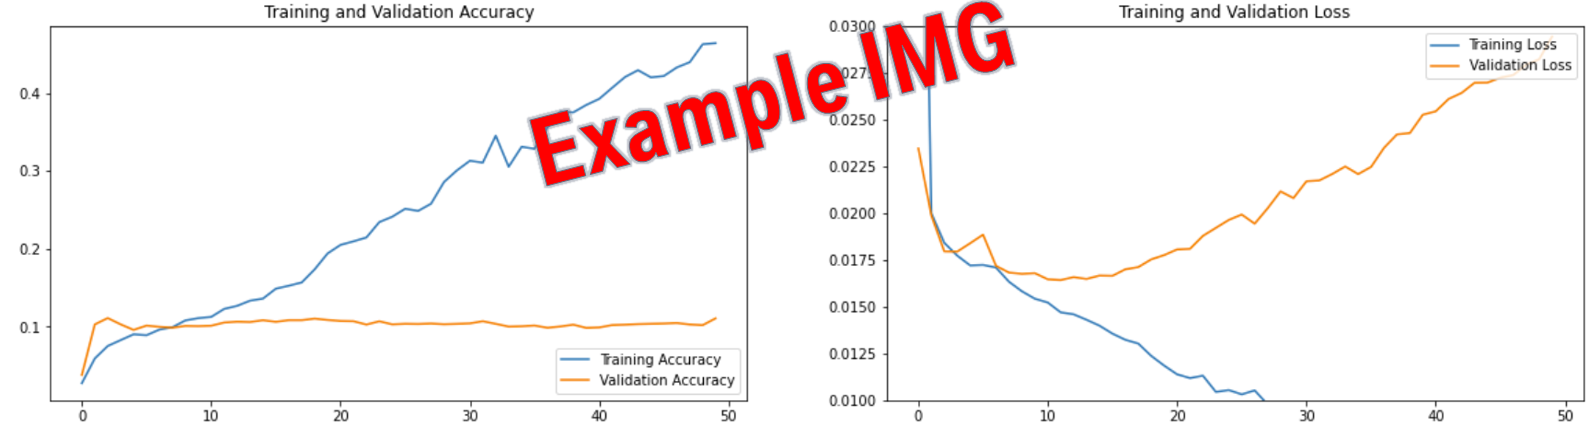 Long before we hit the 10th epoch, the validation loss is increasing again, while the training loss keeps decreasing. We can also clearly ovserve that there is no improvement in our accuracy anymore. 

What can we do against strongly overfitting models?
We could do the following:

* Collect more training data or use augmentation to generate new data: Sadly I have no brilliant idea on how to do this for this specific Kaggle competition.
* Reduce the network’s size (width andor/ dept) by removing layers or reducing the number of neurons in the hidden layers
* Use regularization like LASSO (=Least Absolute Shrinkage and Selection Operator; aka L1 regularization) or Ridge (aka L2 regularization) which results in adding a cost-term to the loss function
* Use higher dropout-rate in the Dropout-Layers, which will randomly remove more connections by setting them to zero and forcing the network to generalize better (=avoid relying on a limitied number of strong-influence neurons).

But now check our model's result and evaluate it:

In [ ]:
## PLOT results
# fetch results from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

# create subplots
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
# limit y-values for beter zoom-scale
#plt.ylim(0.05, 0.4) 
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
# limit y-values for beter zoom-scale
plt.ylim(0, 0.2) 
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

### OOF Evaluation
I found a great and easy way to evaluate the out-of-fold performance [here](https://www.kaggle.com/simakov/keras-multilabel-neural-network-v1-2) which I adopted in the following. Good values are below 0.016.

In [ ]:
from sklearn.metrics import log_loss

metrics = []
for _target in train_targets_df.columns:
    metrics.append(log_loss(train_targets_df.loc[:, _target], train_preds_df.loc[:, _target]))
print(f'OOF Metric: {np.mean(metrics)}')

### Submission

In [ ]:
sub_df.loc[test_features_df['cp_type']==1, Y_feature_cols] = 0

In [ ]:
sub_df.head()

In [ ]:
sub_df.describe().T

In [ ]:
sub_df.to_csv('submission.csv', index = False)

## <font color='blue'>Thanks a lot for reading, I hope you could gain as much insights from reading this as I got from writing it. If you liked it, an upvote is highly appreciated. If you are interested in more content like this, feel free to follow me! ;)</font>